In [1]:
import numpy as np
import scipy as sp

import numpy.linalg as la
import scipy.linalg as sla
import scipy.sparse.linalg as ssla

from matplotlib import pyplot as plt

from CircuitDiagonalization import *

# Single cavity - Constant boundary conditions

In [ ]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 1000 # Like L
# Circuit parameters
L, C, Cg = 0.66E-9, 144E-13, 1.89E-16
# Number of eigenvalues to compute
nEig = 50
# Mode number
kVec = np.arange(1,nEig+1,1)

# Dispersion relation
disp = np.sqrt(1 - np.cos(kVec*np.pi/Nx))/np.sqrt( Cg/(2*C) + 1 - np.cos(kVec*np.pi/Nx) )

# Compute reference eigenvalues (closed cavity case, Neumann boundary conditions)
refVals, refVecs = JJAResClosedEigs(Nx, L, C, Cg, nEig=nEig, bc="neu")
# Plasma frequency
ω0 = np.sqrt(1/(L*C)) 

#Wk = wk(np.arange(1,nEig+1,1))
# Plot frequencies
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(np.arange(1,nEig,1), np.real(refVals[1:])/ω0 )
ax.plot(np.arange(1,nEig,1), np.real(refVals[1:])/ω0 )
ax.plot(kVec, disp, '--')
#ax.plot(np.arange(1,nEig+1,1), Wk )
ax.set_xticks(np.arange(2,nEig+1,2))
plt.show()

# Plot eigenvectors
x = np.linspace(0,Nx,Nx)
mN = 2 # Mode number to plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(x, np.abs(refVecs[:,mN])**2 )


plt.show()

# Single cavity - Iterative eigenvalue problem for outgoing boundary conditions

In [ ]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 1000 
# Circuit parameters
L, C, Cg = 1.0, 1*100.0, 1.0
# Waveguide parameters
LW, CW = 1.0, 1.0
# Outcoupling parameters
Cin, Cout = 1.0, 1.0 # Compare to (Cg+2C)*Nx
# Reference eigenvalue
# kRef = [0.04]
# kRef = np.real(refVals[1:20])
kRef = np.real(refVals)
nCom = len(kRef)

# Solve eigenvalue problem
kVals, spEigVecs, errVals = JJAResOpenEigs(Nx, L, C, Cg, LW, CW, Cin, Cout, kRef, errTol=1e-5, itNum=5, disp="on")


In [ ]:
# Plot real and imaginary parts
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(np.real(kVals), -np.imag(kVals) )
# ax.set_xticks(np.arange(2,nCom+1,2))
ax.set_ylim([-0.000001, -1.1*np.min(np.imag(kVals))])
ax.set_ylabel('κn')
ax.set_xlabel('ωn')
plt.show()
np.real(kVals)

In [ ]:
# Plot eigenvectors
x = np.linspace(-1,Nx-1,Nx)
mN = 31 # Mode number to plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(x, np.abs(spEigVecs[:,mN])**2 )
ax.set_title('Eigenvalue: ' + str(kVals[mN]))
plt.show()

## Iterative solver

In [ ]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 1000 # Like L
# Circuit parameters
L, C, Cg = 0.66E-9, 144E-13, 1.89E-16
# Number of eigenvalues to compute
nEig = 10
# Waveguide parameters from http://alignment.hep.brandeis.edu/Lab/XLine/XLine.html
LW, CW = 2.52E-9, 1.01E-12
# Outcoupling parameters value taken from Masluk et al PRL 2012
Cin, Cout = 7E-12, 7E-12

eigVals, eigVecs = JJAResOpenIterEigs(Nx, L, C, Cg, LW, CW, Cin, Cout, nEig=nEig, errTol=1e-5, itNum=5, capItNum=10, disp="off")

In [ ]:
Cin/((Cg+2*C)*Nx)

In [ ]:
# Plasma frequency
ω0 = np.sqrt(1/(L*C)) 

# Plot real and imaginary parts
fig, axs = plt.subplots(1, 2, figsize=(16,6))
ax = axs[0]
# ax.scatter(np.real(eigVals)*Nx/np.pi, -np.imag(eigVals)*Nx/np.pi )
ax.scatter(np.real(eigVals)/ω0, -np.imag(eigVals)/ω0 )
# ax.set_xticks(np.arange(2,nCom+1,2))
# ax.set_ylim([-0.000001/ω0, -1.1*np.min(np.imag(eigVals))/ω0])
ax.set_xlabel('ωn/π')
ax.set_ylabel('κn/π')

ax = axs[1]
ax.scatter(np.arange(1,nEig,1), np.real(eigVals)/ω0 )
ax.plot(np.arange(1,nEig,1), np.real(eigVals)/ω0 )
ax.set_xlabel('n')
ax.set_ylabel('ωn/π')
plt.show()

In [ ]:
np.imag(eigVals[1:])

In [ ]:
ω0/(10**9)

# Even-Odd Coupled JJAs closed

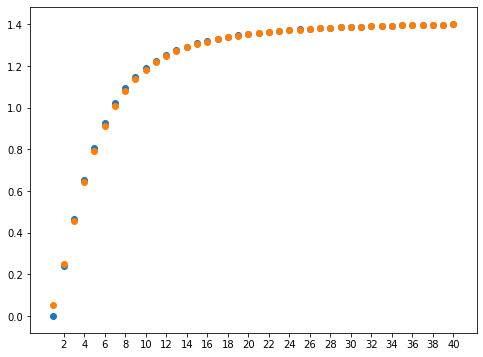

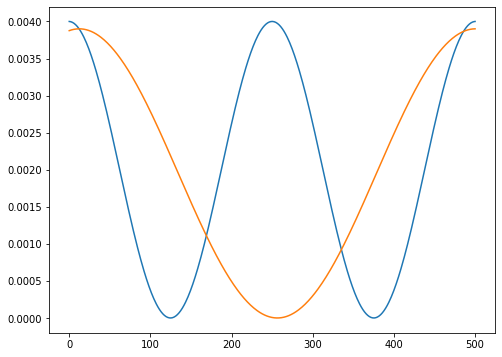

In [6]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 1000 # Like L
# Circuit parameters
L, C, Cg = 0.66E-9, 144E-15, 1.89E-16
# Junction parameters
wJ, Csh = 1.8E9, 3E-15

# Number of eigenvalues to compute
nEig = 40

# Compute reference eigenvalues (closed cavity case, Neumann boundary conditions)
refVals1,refVals2, refVecs1,refVecs2 = JJACoupledClosedEigs(Nx, L, C, Cg, wJ, Csh, nEig=nEig, bc="neu")

# Plot frequencies
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.scatter(np.arange(1,nEig+1,1), np.real(refVals1) )
# ax.plot(np.arange(1,nEig+1,1), np.real(refVals1) )

ax.scatter(np.arange(1,nEig+1,1), np.real(refVals2) )
# ax.plot(np.arange(1,nEig+1,1), np.real(refVals2) )
ax.set_xticks(np.arange(2,nEig+1,2))
plt.show()
NN = round(Nx/2)
# Plot eigenvectors
x = np.linspace(0,NN,NN)
mN = 1 # Mode number to plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Construct original basis eigenvectors
ΦL = np.zeros( (NN,nEig-1), dtype=complex)
ΦR = np.zeros( (NN,nEig-1), dtype=complex)
for n in range(1,nEig-1):
    mN = n
    Φp = refVecs1[:,mN+0]
    Φm = refVecs1[:,mN-1]
    
    ΦL[:,n] = (Φp/la.norm(Φp) + Φm/la.norm(Φm))
    ΦR[:,n] = (Φp/la.norm(Φp) - Φm/la.norm(Φm))
    # Flip ΦL
    ΦL[:,n] = ΦL[::-1,n]

# Mode number
mN = 2
# ax.plot(x, np.abs(ΦL[:,mN])**2 )
# ax.plot(NN+x, np.abs(ΦR[:,mN])**2 )
ax.plot(x, np.abs(refVecs1[:,mN]/la.norm(refVecs1[:,mN]))**2 )
ax.plot(x, np.abs(refVecs2[:,mN-1]/la.norm(refVecs2[:,mN-1]))**2 )
plt.show()

# Even-Odd Coupled JJAs open

In [ ]:
# System parameters
# Grid size (number of LC units in JJA resonator) 
Nx = 1000 # Like L
# Circuit parameters
L, C, Cg = 0.66E-9, 144E-15, 1.89E-16
# Junction parameters
wJ, Csh = 1.8E9, 3E-15
# Waveguide parameters from http://alignment.hep.brandeis.edu/Lab/XLine/XLine.html
LW, CW = 2.52E-9, 1.01E-12
# Outcoupling parameters value taken from Masluk et al PRL 2012
Cin, Cout = 7E-16, 7E-16
# Number of eigenvalues to compute
nEig = 10

eigVals1, eigVals2, eigVecs1, eigVecs2 = JJACoupledOpenIterEigs(Nx, L, C, Cg,wJ, Csh, LW, CW, Cin, Cout, nEig=40, errTol=1e-5, itNum=5, capItNum=5, disp="on")


# Plot real and imaginary parts
fig, axs = plt.subplots(1, 2, figsize=(16,6))
ax = axs[0]
ax.scatter(np.real(eigVals1)*NN/np.pi, -np.imag(eigVals1)*NN/np.pi )
# ax.set_xticks(np.arange(2,nCom+1,2))
ax.set_ylim([-0.000001*NN/np.pi, -1.1*np.min(np.imag(eigVals1))*NN/np.pi])
ax.set_xlabel('ωn/π')
ax.set_ylabel('κn/π')

ax = axs[1]
ax.scatter(np.arange(1,nEig,1), np.real(eigVals1)*NN/np.pi )
ax.plot(np.arange(1,nEig,1), np.real(eigVals1)*NN/np.pi )
ax.set_xlabel('n')
ax.set_ylabel('ωn/π')
plt.show()